In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
df = pd.read_excel('/content/output_iou.xlsx')

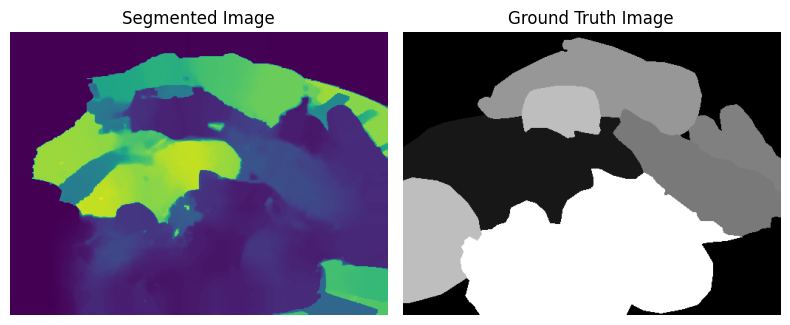

0.7846224102292938


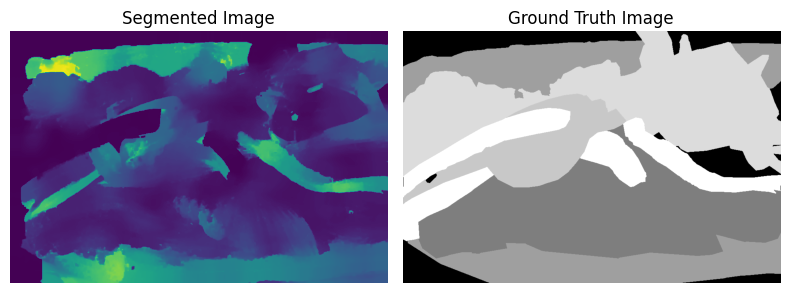

0.9136907562036928


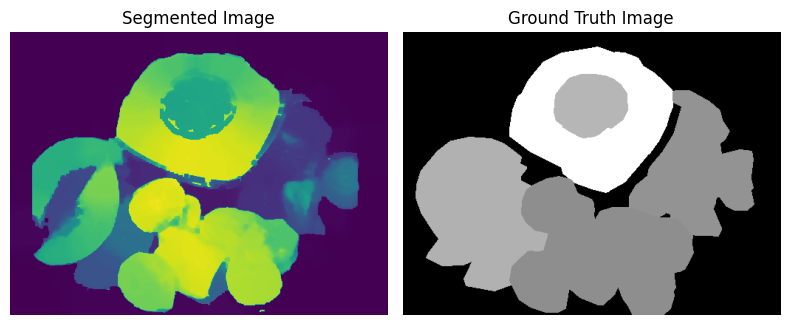

0.7802050189109684


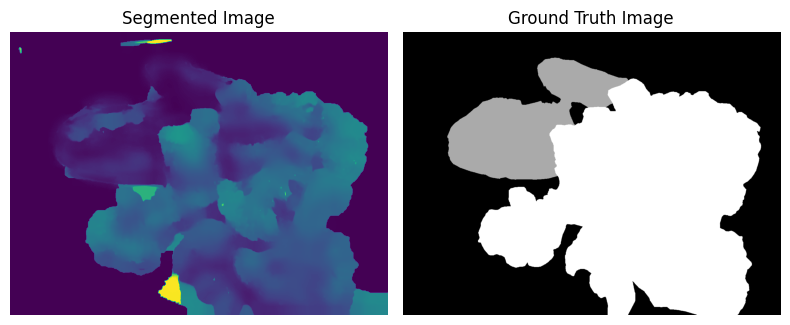

0.8473637838408281


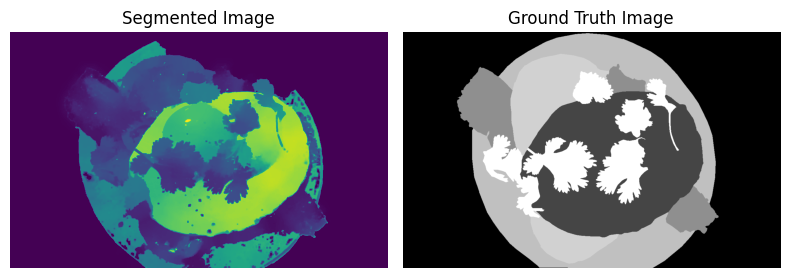

0.898576644397678


In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    # Convert to RGB and normalize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Gamma correction for light adjustment
    gamma = 1.8
    img = np.clip(img ** gamma, 0, 1)

    return img

# Function for GrabCut segmentation to isolate food items
def grabcut_segmentation(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Define the rectangle around the food region
    rect = (30, 30, image.shape[1] - 30, image.shape[0] - 30)

    # Apply GrabCut
    cv2.grabCut((image * 255).astype(np.uint8), mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)

    # Create a mask where definite and probable foreground are marked as 1, others as 0
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Apply the mask to the input image
    segmented_image = image * mask2[:, :, np.newaxis]

    # Convert to 8-bit integer format for further processing
    segmented_image_8bit = (segmented_image * 255).astype(np.uint8)

    return segmented_image_8bit

# Function for unsupervised segmentation using Mean Shift algorithm
def mean_shift_segmentation(image):
    ms_clustering = cv2.pyrMeanShiftFiltering(image, 30, 60)
    segmented_image = cv2.cvtColor(ms_clustering, cv2.COLOR_RGB2GRAY)

    return segmented_image

# Function for post-processing the segmented image
def postprocess_segmentation(segmented_img):
    kernel = np.ones((5, 5), np.uint8)
    segmented_img = cv2.morphologyEx(segmented_img, cv2.MORPH_CLOSE, kernel)

    return segmented_img

# Function to calculate mIoU
def calculate_mIoU(segmented_img, ground_truth):
    intersection = np.logical_and(segmented_img, ground_truth)
    union = np.logical_or(segmented_img, ground_truth)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Folder paths
img_folder = '/content/drive/MyDrive/Images/img_dir'
ground_truth_folder = '/content/drive/MyDrive/Images/ann_dir'

# Get a list of filenames from the 'img' folder
img_filenames = os.listdir(img_folder)
specific_images = ['00007105.jpg', '00005030.jpg', '00005145.jpg', '00004892.jpg', '00004967.jpg']

# Calculate mIoU for each image
for img_filename in specific_images:
    # Read input image
    input_image_path = os.path.join(img_folder, img_filename)
    input_image = cv2.imread(input_image_path)

    # Read corresponding ground truth image
    gt_filename = img_filename.split('.')[0] + '.png'
    ground_truth_path = os.path.join(ground_truth_folder, gt_filename)
    ground_truth_image = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

    # Preprocess the image
    input_image = preprocess_image(input_image_path)

    # GrabCut segmentation to isolate food items
    grabcut_segmented = grabcut_segmentation(input_image)

    # Mean Shift segmentation on GrabCut result
    mean_shift_segmented = mean_shift_segmentation(grabcut_segmented)

    # Post-process the segmentation
    processed_segmentation = postprocess_segmentation(mean_shift_segmented)
    # Resize segmented image to match ground truth image dimensions
    processed_segmentation_resized = cv2.resize(processed_segmentation, (ground_truth_image.shape[1], ground_truth_image.shape[0]))
    # Calculate mIoU
    iou_score = calculate_mIoU(processed_segmentation_resized, ground_truth_image)

    # Display segmented image and ground truth image for comparison
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(processed_segmentation_resized)
    plt.title('Segmented Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.title('Ground Truth Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(iou_score)


In [ ]:
mean_value = df['IoU Score'].mean()
print(mean_value)

0.5759320648594469


In [15]:
df.head(5)

,Unnamed: 0,Input Image Path,Ground Truth Image Path,IoU Score
0,0,/content/drive/MyDrive/Images/img_dir/00004858...,/content/drive/MyDrive/Images/ann_dir/00004858...,0.539045
1,1,/content/drive/MyDrive/Images/img_dir/00004866...,/content/drive/MyDrive/Images/ann_dir/00004866...,0.724525
2,2,/content/drive/MyDrive/Images/img_dir/00004885...,/content/drive/MyDrive/Images/ann_dir/00004885...,0.624404
3,3,/content/drive/MyDrive/Images/img_dir/00004874...,/content/drive/MyDrive/Images/ann_dir/00004874...,0.317832
4,4,/content/drive/MyDrive/Images/img_dir/00004871...,/content/drive/MyDrive/Images/ann_dir/00004871...,0.565741


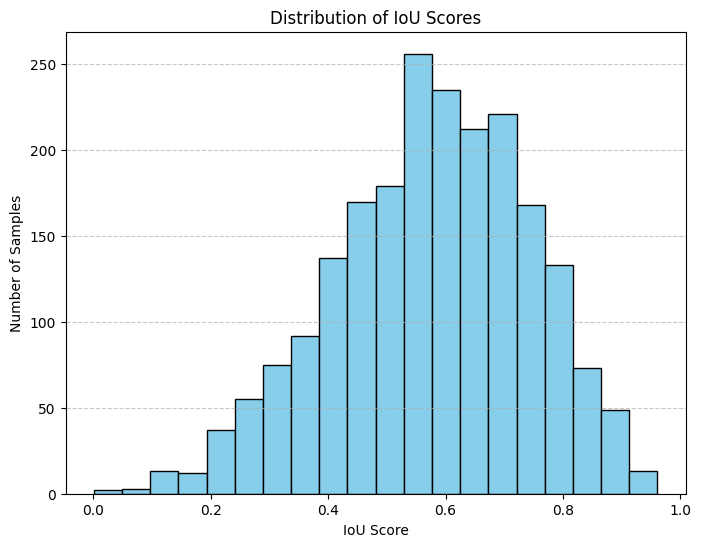

In [20]:
iou_scores = df['IoU Score']

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(iou_scores, bins=20, color='skyblue', edgecolor='black')  # Adjust bins as needed
plt.xlabel('IoU Score')
plt.ylabel('Number of Samples')
plt.title('Distribution of IoU Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

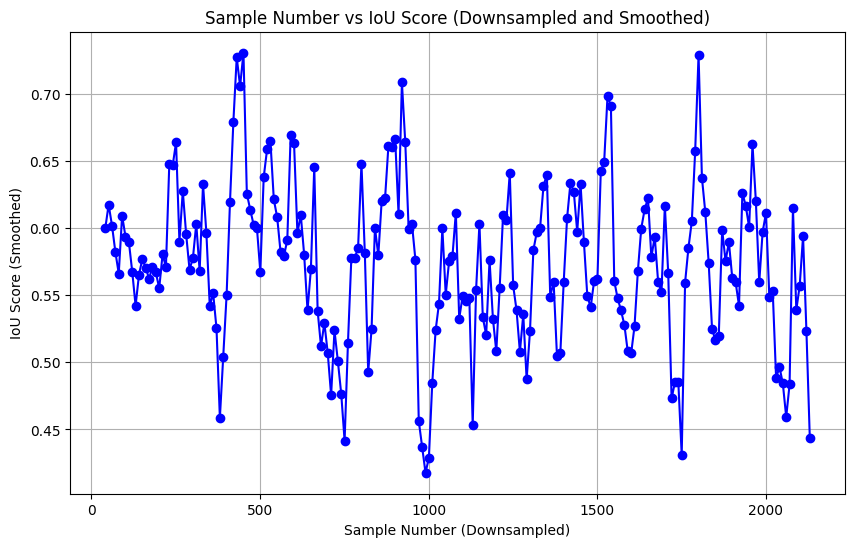

In [35]:
# Get the IoU scores from the DataFrame
iou_scores = df['IoU Score']

# Downsample the data to plot every 10th sample for better readability
downsampled_iou_scores = iou_scores[::10]  # Adjust the sampling rate as needed

# Apply a moving average for smoothing
window_size = 5
smoothed_iou_scores = downsampled_iou_scores.rolling(window_size).mean()

# Create a line chart for Sample Numbers vs IoU Scores
plt.figure(figsize=(10, 6))  # Increase figure size
plt.plot(range(1, len(iou_scores) + 1, 10), smoothed_iou_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Sample Number (Downsampled)')
plt.ylabel('IoU Score (Smoothed)')
plt.title('Sample Number vs IoU Score (Downsampled and Smoothed)')
plt.grid(True)
plt.show()